# Siamese Network Architecture using MNIST Dataset

In [16]:
# -*- encoding: utf-8 -*-
import argparse
import torch
import torchvision.datasets as dsets
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import transforms
import pickle
import torch
import torch.nn as nn

### Data Preprocessing
For Siamese Network, we want data in pairs: 1 pair-> similar, 1 pair-> dissimilar.

In [17]:
class Dataset(object):
    def __init__(self, x0, x1, label):
        self.size = label.shape[0]
        self.x0 = torch.from_numpy(x0)
        self.x1 = torch.from_numpy(x1)
        self.label = torch.from_numpy(label)

    def __getitem__(self, index):
        return (self.x0[index],
                self.x1[index],
                self.label[index])

    def __len__(self):
        return self.size

def create_pairs(data, digit_indices):
    x0_data = []
    x1_data = []
    label = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            x0_data.append(data[z1] / 255.)
            x1_data.append(data[z2] / 255.)
            label.append(1)
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            x0_data.append(data[z1] / 255.)
            x1_data.append(data[z2] / 255.)
            label.append(0)

    x0_data = np.array(x0_data, dtype=np.float32)
    x0_data = x0_data.reshape([-1, 1, 28, 28])
    x1_data = np.array(x1_data, dtype=np.float32)
    x1_data = x1_data.reshape([-1, 1, 28, 28])
    label = np.array(label, dtype=np.int32)
    return x0_data, x1_data, label


def create_iterator(data, label, batchsize, shuffle=False):
    digit_indices = [np.where(label == i)[0] for i in range(10)]
    x0, x1, label = create_pairs(data, digit_indices)
    ret = Dataset(x0, x1, label)
    return ret


# Loss Function: Contrastive Loss Function 

In [18]:
def contrastive_loss_function(x0, x1, y, margin=1.0):
    # euclidian distance
    diff = x0 - x1
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dist = torch.sqrt(dist_sq)

    mdist = margin - dist
    dist = torch.clamp(mdist, min=0.0)
    loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
    loss = torch.sum(loss) / 2.0 / x0.size()[0]
    return loss

# Defining Siamese Network Architecture

In [19]:
class SiameseNetwork(nn.Module):
    def __init__(self,flag_kaf=False):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.MaxPool2d(2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(50 * 4 * 4, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500,10),
            nn.Linear(10, 2))
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [20]:
def plot_mnist(numpy_all, numpy_labels,name="./embeddings_plot.png"):
        c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
             '#ff00ff', '#990000', '#999900', '#009900', '#009999']

        for i in range(10):
            f = numpy_all[np.where(numpy_labels == i)]
            plt.plot(f[:, 0], f[:, 1], '.', c=c[i])
        plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
        plt.savefig(name)

In [21]:
batchsize=128
train = dsets.MNIST(root='../data/',train=True,download=True)
test = dsets.MNIST(root='../data/',train=False,transform=transforms.Compose([transforms.ToTensor(),]))
indices= np.random.choice(len(train.train_labels.numpy()), 5000, replace=False)
indices_test= np.random.choice(len(test.test_labels.numpy()), 50, replace=False)
print (indices_test)

[7022 8249 7453 1906 6616 5439 5371 6072 9906 6846 6958 4870 5656 9814
 3201 8059 3720 6140 6704 9563 7028 2172 7795 6743 1256 5457 8997 1352
 3522 9901 2961 9796 3435 5447 3044 3729 4210 5339 1031 8327 1236 5887
  714 1633 1120 2219 6436 4880 2128 2624]


/Users/sjadon/anaconda3/envs/mysite/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/sjadon/anaconda3/envs/mysite/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [22]:
train_iter = create_iterator(train.train_data.numpy()[indices],train.train_labels.numpy()[indices],batchsize)
test_iter = create_iterator(test.test_data.numpy()[indices_test],test.test_labels.numpy()[indices_test],batchsize)
# model
model = SiameseNetwork()
learning_rate = 0.01
momentum = 0.9
# Loss and Optimizer
criterion = contrastive_loss_function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=momentum)
#kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
kwargs = {}
train_loader = torch.utils.data.DataLoader(train_iter,batch_size=batchsize, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test,batch_size=batchsize, shuffle=True, **kwargs)

/Users/sjadon/anaconda3/envs/mysite/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/sjadon/anaconda3/envs/mysite/lib/python3.6/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [23]:
train_loss = []
running_loss=0.0
epochs =100
for epoch in range(epochs):
    print('Train Epoch:'+str(epoch)+"------------------>")
    for batch_idx, (x0, x1, labels) in enumerate(train_loader):
        labels = labels.float()
        x0, x1, labels = Variable(x0), Variable(x1), Variable(labels)
        output1, output2 = model(x0, x1)
        loss = criterion(output1, output2, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if batch_idx % batchsize == 0:
            print('Batch id: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx, batch_idx * len(labels), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    #torch.save(model.state_dict(), './model-epoch-%s.pth' % epoch)


Train Epoch:0------------------>
Batch id: 0 [0/8660 (0%)]	Loss: 0.218648
Train Epoch:1------------------>
Batch id: 0 [0/8660 (0%)]	Loss: 0.099945
Train Epoch:2------------------>
Batch id: 0 [0/8660 (0%)]	Loss: 0.108186
Train Epoch:3------------------>
Batch id: 0 [0/8660 (0%)]	Loss: 0.081205
Train Epoch:4------------------>
Batch id: 0 [0/8660 (0%)]	Loss: 0.078149
Train Epoch:5------------------>
Batch id: 0 [0/8660 (0%)]	Loss: 0.073436
Train Epoch:6------------------>
Batch id: 0 [0/8660 (0%)]	Loss: 0.060201
Train Epoch:7------------------>
Batch id: 0 [0/8660 (0%)]	Loss: 0.061203
Train Epoch:8------------------>
Batch id: 0 [0/8660 (0%)]	Loss: 0.050953
Train Epoch:9------------------>
Batch id: 0 [0/8660 (0%)]	Loss: 0.055849
Train Epoch:10------------------>
Batch id: 0 [0/8660 (0%)]	Loss: 0.037618
Train Epoch:11------------------>
Batch id: 0 [0/8660 (0%)]	Loss: 0.046342
Train Epoch:12------------------>
Batch id: 0 [0/8660 (0%)]	Loss: 0.038315
Train Epoch:13------------------>
B

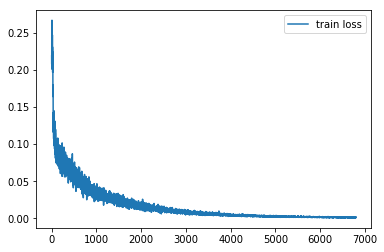

In [24]:
def plot_loss(train_loss,name="train_loss.png"):
    plt.plot(train_loss, label="train loss")
    plt.legend()
plot_loss(train_loss)

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
def test_model(model):
        model.eval()
        all_ = []
        all_labels = []
        #original_labels=[]
        for batch_idx, (x, labels) in enumerate(test_loader):
            x, labels = Variable(x, volatile=True), Variable(labels)
            output = model.forward_once(x)
            all_.extend(output.data.cpu().numpy().tolist())
            all_labels.extend(labels.data.cpu().numpy().tolist())

        numpy_all = np.array(all_)
        numpy_labels = np.array(all_labels)
        return numpy_all, numpy_labels

def testing_plots(name_file,model):
        filehandler = open(name_file,"wb")
        dict_pickle={}
        numpy_all, numpy_labels = test_model(model)
        dict_pickle["numpy_all"]=numpy_all
        dict_pickle["numpy_labels"]=numpy_labels
        pickle.dump(dict_pickle,filehandler)
        plot_mnist(numpy_all, numpy_labels)
        filehandler.close()

/Users/sjadon/anaconda3/envs/mysite/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


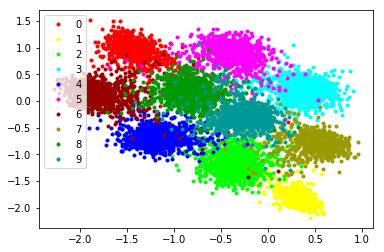

In [26]:
#test_model(model)
testing_plots("abc.pickle",model)